In [46]:
library(ggplot2)
library(readxl)
library(tidyr)
library(forcats)
library(jsonlite)
library(stringr)
library(tidyverse)

The first thing to do is to import the JSON data from the survey system.  There is some nontrivial munging for which Rich Salaay has the script.  Here, I assume that we get JSON from Rich, and that the data is further hand-cleaned to take care of data entry issues.

The key point is to arrange things into a data frame, where the column "header" is actually a question from the survey, and "value" is the answer to that question.  The questions in the survey form include responses to the per-task, post-task, and SUS, as well as 'SCORE' which is the manual assessment of participant task success.

In [3]:
jsontext <- readLines("CHT_Participant_Survey_Data_7_28.json")
jsons <- lapply(jsontext, fromJSON)
df <- as.data.frame(do.call(rbind, tail(jsons, -1)))
names(df) <- c("participant", "question", "system", "header", "value")
summary(df)

  participant      question           system    
 28     : 530   DEMO   : 462   DIG       :1284  
 13     : 281   1      : 230   N/A       : 539  
 3      : 281   2      : 168   Tellfinder:1296  
 14     : 269   4      : 156                    
 11     : 247   6      : 144                    
 12     : 247   8      : 144                    
 (Other):1264   (Other):1815                    
                                                                                                       header    
 SCORE                                                                                                    : 193  
 Do you feel that this question was operationally relevant or useful in your investigative search process?: 191  
 Please list any comments about the question or workflow.                                                 : 191  
 Post-task Questionnaire                                                                                  : 191  
 Tool Usage [I would have to use anoth

Here is the absolute top level view: is there a difference in participant score between the two systems?

Warning message in evalq(as.integer(as.character(value)), <environment>):
“NAs introduced by coercion”Warning message:
“Removed 11 rows containing non-finite values (stat_boxplot).”

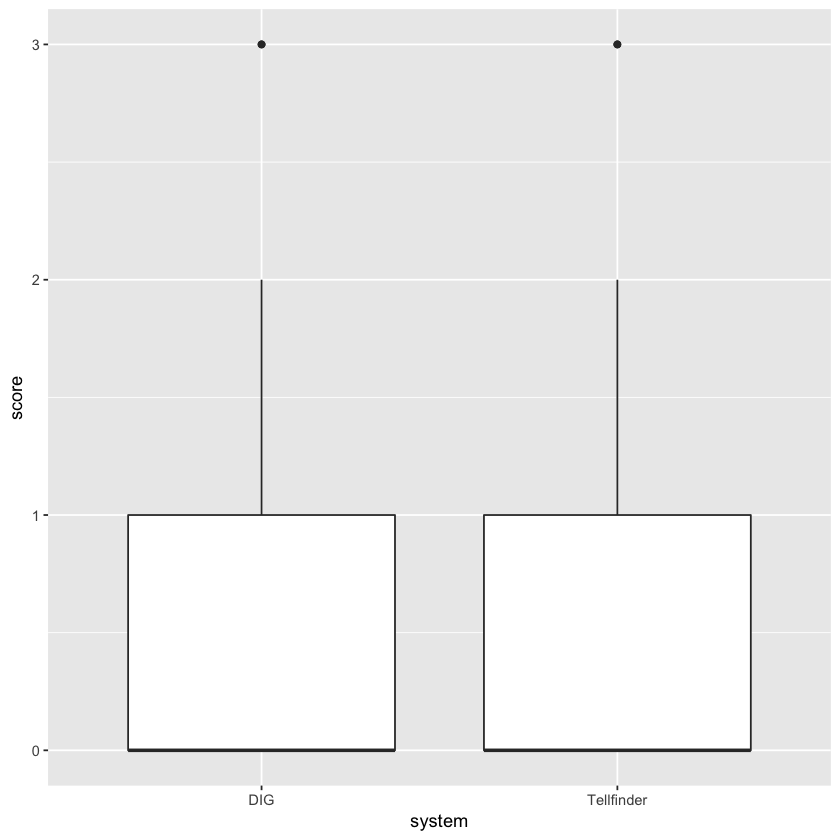

In [32]:
scores <- df %>% 
    filter(header == 'SCORE') %>%
    mutate(score = as.integer(as.character(value)))
ggplot(scores, aes(system, score)) + geom_boxplot()

In order to work with the demographic data, I'm going to recode that part of the table to it easier.

In [ ]:
demog <- df %>% filter(question == 'DEMO') %>%
    mutate(header = fct_recode(header, 
        "participant_id" = "Please enter your participant ID number.åÊ",
        "years_analyst" = "How many years of experience do you have as an analyst or investigator?",
        "years_cht" = "How many years of experience do you have specifically in counter-human-trafficking investigations or analysis?",
        "hours_online" = "How many hours per week do you spend online researching information relating to Counter-HT leads?",
        "dig_exp" = "Tell us about your prior experience using the Memex tools. [Do you have prior experience with this tool? (y/n)][DIG]",
        "tf_exp" = "Tell us about your prior experience using the Memex tools. [Do you have prior experience with this tool? (y/n)][Tellfinder]",
        "dig_years" = "Tell us about your prior experience using the Memex tools. [If so, how long is that experience? (\"NA\", \"# of years\")][DIG]",
        "tf_years" = "Tell us about your prior experience using the Memex tools. [If so, how long is that experience? (\"NA\", \"# of years\")][Tellfinder]",
        "dig_rating" = "Rate your expertise with each tool by on a scale of 1(Basic) to 5(Power User). [DIG]",
        "tf_rating" = "Rate your expertise with each tool by on a scale of 1(Basic) to 5(Power User). [Tellfinder]",
        "other_rating" = "Rate your expertise with other tools used by on a scale of 1(Basic) to 5(Power User). [Other Tools Used]"
    )) %>%
    filter(participant != '') %>%
    mutate(value = fct_collapse(value, 
                                 y = c("y", "Y", "Yes", "yes"),
                                 n = c("n", "N", "No", "no")
                                )) %>%
    select(-question, -system) %>%
    distinct(participant, header, .keep_all = TRUE) %>%
    spread(header, value) %>%
    select(participant, contains("_"))

And then join the demographic data with the scores so we can analyze scores at different levels of participant experience.

Joining, by = "participant"
Warning message:
“Removed 11 rows containing non-finite values (stat_boxplot).”Warning message:
“position_dodge requires non-overlapping x intervals”Warning message:
“position_dodge requires non-overlapping x intervals”

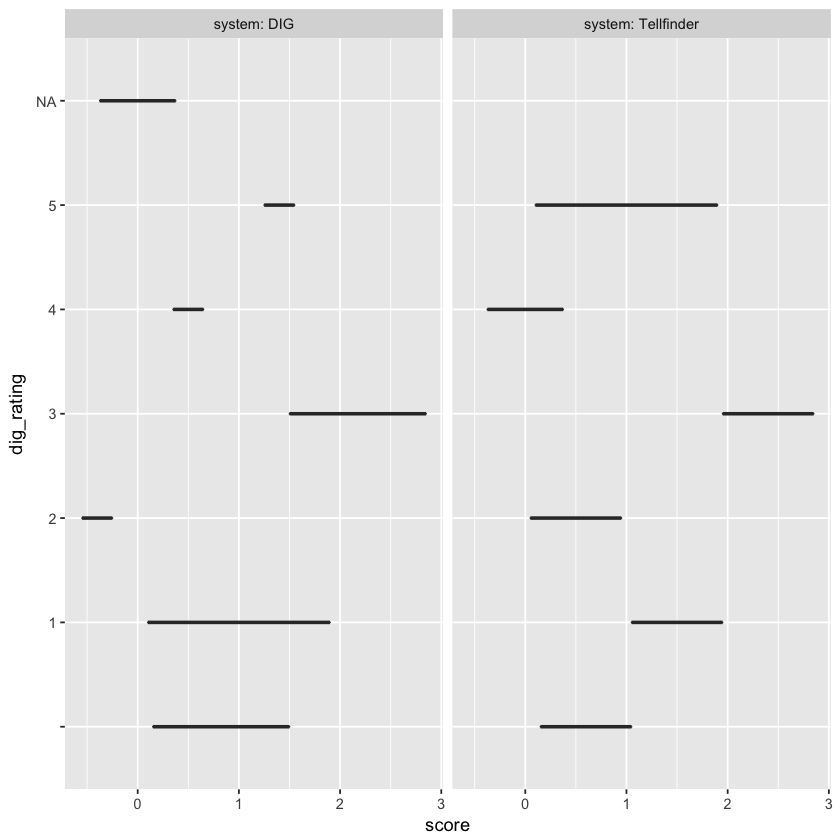

In [31]:
demo_scores <- scores %>% left_join(demog)
ggplot(demo_scores, aes(score, dig_rating)) + geom_boxplot() + facet_wrap(~system, labeller="label_both")

Next, I want to look at the time it takes for participants to complete questions.  I'm going to trim out times longer than 20 minutes, to focus on questions fitting in our notion of the appropriate timeframe.

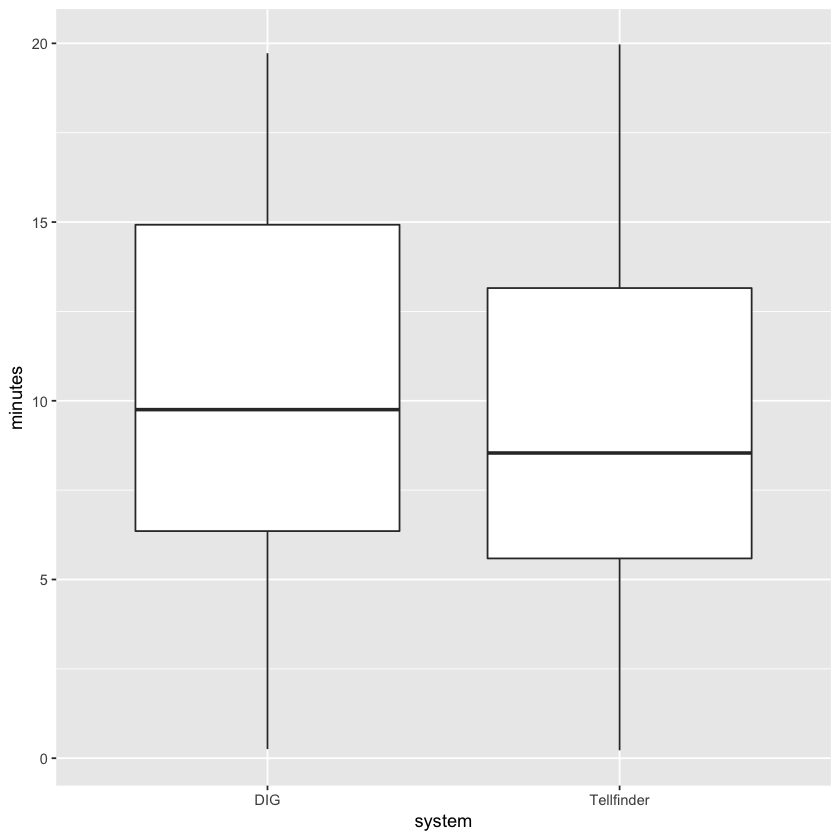

In [52]:
times <- df %>% 
    filter(str_detect(header, "Group time")) %>%
    filter(question != "DEMO") %>%
    mutate(minutes = parse_number(value) / 60.0) %>%
    filter(minutes < 20.0)
ggplot(times, aes(system, minutes)) + geom_boxplot()